# Compare Drought Events

a. stein 7.14.2022

Following the work developed in `explore/drought_event_tracking.ipynb`, this notebook summarizes the methodology and provides space for analysis.

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import rioxarray
import rasterio as rio
import pandas as pd
import geopandas as gpd

import matplotlib.dates as mdates

from tqdm.autonotebook import tqdm

import sys
sys.path.append('../../')
import ndrought.wrangle as wrangle
import ndrought.compare as compare
import ndrought.plotting as ndplot

Populating the interactive namespace from numpy and matplotlib


/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [3]:
dm_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures'

spi_intervals = ['14d', '30d', '90d', '180d', '270d', '1y', '2y', '5y', ]
cats = ['neutral_wet', 'D0', 'D1', 'D2', 'D3', 'D4']

dm_vars = ['USDM']
dm_vars.extend([f'spi_{interval}' for interval in spi_intervals])

paired_ds = xr.open_dataset(f'{dm_path}/ndrought_products/paired_USDM_SPI.nc')

In [4]:
paired_ds

<xarray.Dataset>
Dimensions:      (lat: 84, lon: 188, index: 1148)
Coordinates:
  * lat          (lat) float64 48.98 48.94 48.9 48.86 ... 45.61 45.57 45.53
  * lon          (lon) float64 -124.7 -124.7 -124.6 ... -117.0 -117.0 -116.9
  * index        (index) int64 0 1 2 3 4 5 6 ... 1142 1143 1144 1145 1146 1147
Data variables:
    spatial_ref  int64 ...
    USDM         (index, lat, lon) float64 ...
    USDM Date    (index) datetime64[ns] ...
    spi_1y       (index, lat, lon) float32 ...
    spi_2y       (index, lat, lon) float32 ...
    spi_5y       (index, lat, lon) float32 ...
    spi_14d      (index, lat, lon) float32 ...
    spi_30d      (index, lat, lon) float32 ...
    spi_90d      (index, lat, lon) float32 ...
    spi_180d     (index, lat, lon) float32 ...
    spi_270d     (index, lat, lon) float32 ...
    SPI Date     (index) datetime64[ns] ...
Attributes:
    author:       a. stein 6/8/2022
    description:  USDM and SPI matched to USDM data cutoff dates, as describe...
    USDM Date:    this contains the original dates for USDM
    SPI Date:     this contains the original dates for SPI

### Drought Event Encoding

The method I propose is a modification on Pfaffstetter encoding, which nicely handles diverging/bifurcating/splitting objects, but does not address joining objects since it is designed for river networks which only split one way (note that this is defined for river networks by going upstream). To address this, I propose adding a "." as a delimiter in the string to store events. The larger of the two events becomes the primary event occurring and would retain the front-most space ahead of all the "." while following it is it's history until completion. The other problem with Pfaffstetter encoding is that by relying solely on digits, it can only hold up to 9 different categories at the topmost level ... which for is great for river basins but there will likely be more then 9 independent drought events in an entire time series. To address this, I propose adding a "-" to denote a split.

Event X on at it's start, if it's start is independent, would only have code "1" ... while event Y starting at the same time would have code "2". Now, let's say that event X split into 2 events A and B, this would give us codes "1-1" for A and "1-2" for B, (although which one has a second digit of "2" is arbitrary). This allows us to identify that events A and B came from event X because their first digit is "1". Now let's say that event Y merges with event A. The combination of Y and A would produce code "2.1-1" if Y is bigger, and "1-2.2" if A is bigger. By storing the consumed event after a ".", we do not loose the history of the event and can follow it throughout. Now let's assume Y was bigger so that we get "2.1-1" for this new event we'll call M. If then a new event Z emerged, this would have code "3" ... which is then oblivious to the other events if it emerges independent of them (e.g. not from a split). Let's say we wanted to then how event X changed over time, we can then search for codes that start with "1" (since in this scenario event B still exists) and for codes that have ".1" in them, indicating that it got consumed in some other event along the way. From this search we would get the times with codes "1", "1-1", "1-2", and "2.1-1". From this we can then plot how the area changes over time through a stacked line chart that would show what percentage of total event X is then in each "1-2" and "1-1" and so forth. 

If you would like to see original testing and demonstration of this example, check out `explore/drought_event_tracking.ipynb`

### Testing with Cellular Automata

In [5]:
# code from: https://towardsdatascience.com/simple-but-stunning-animated-cellular-automata-in-python-c912e0c156a9

powers_of_two = np.array([[4], [2], [1]])  # shape (3, 1)

def step(x, rule_binary):
    """Makes one step in the cellular automaton.
    Args:
        x (np.array): current state of the automaton
        rule_binary (np.array): the update rule
    Returns:
        np.array: updated state of the automaton
    """
    x_shift_right = np.roll(x, 1)  # circular shift to right
    x_shift_left = np.roll(x, -1)  # circular shift to left
    y = np.vstack((x_shift_right, x, x_shift_left)).astype(np.int8)  # stack row-wise, shape (3, cols)
    z = np.sum(powers_of_two * y, axis=0).astype(np.int8)  # LCR pattern as number

    return rule_binary[7 - z]

def cellular_automaton(rule_number, size, steps,
                       init_cond='random', impulse_pos='center'):
    """Generate the state of an elementary cellular automaton after a pre-determined
    number of steps starting from some random state.
    Args:
        rule_number (int): the number of the update rule to use
        size (int): number of cells in the row
        steps (int): number of steps to evolve the automaton
        init_cond (str): either `random` or `impulse`. If `random` every cell
        in the row is activated with prob. 0.5. If `impulse` only one cell
        is activated.
        impulse_pos (str): if `init_cond` is `impulse`, activate the
        left-most, central or right-most cell.
    Returns:
        np.array: final state of the automaton
    """
    assert 0 <= rule_number <= 255
    assert init_cond in ['random', 'impulse']
    assert impulse_pos in ['left', 'center', 'right']
    
    rule_binary_str = np.binary_repr(rule_number, width=8)
    rule_binary = np.array([int(ch) for ch in rule_binary_str], dtype=np.int8)
    x = np.zeros((steps, size), dtype=np.int8)
    
    if init_cond == 'random':  # random init of the first step
        x[0, :] = np.array(np.random.rand(size) < 0.5, dtype=np.int8)

    if init_cond == 'impulse':  # starting with an initial impulse
        if impulse_pos == 'left':
            x[0, 0] = 1
        elif impulse_pos == 'right':
            x[0, size - 1] = 1
        else:
            x[0, size // 2] = 1
    
    for i in range(steps - 1):
        x[i + 1, :] = step(x[i, :], rule_binary)
    
    return x

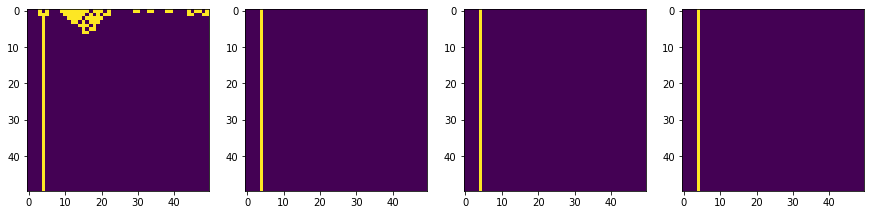

In [96]:
ca_all = cellular_automaton(218, 50, 200)
ca_parsed = 1-np.array([ca_all[(i-1)*50:i*50, :] for i in [1, 2, 3, 4]])

fig, axs = plt.subplots(1, 4, figsize=(15,5))

for i, ax in enumerate(axs.ravel()):
    ax.imshow(ca_parsed[i])

### Analysis of USDM & SPI

In [4]:
USDM_events = wrangle.encode_drought_events(paired_ds['USDM'].values)

Identifying Blobs:   0%|          | 0/1148 [00:00<?, ?it/s]

Encoding Blobs:   0%|          | 0/1147 [00:00<?, ?it/s]

In [5]:
USDM_events['frac_area'] = USDM_events['area']/(84*188)
USDM_events

area  convex_area  \
time drought_id                                 
56   1                       653          665   
57   1                       653          665   
58   1                     12006        13514   
     2                        37           65   
     3                         1            1   
...                          ...          ...   
1144 75.76.77.78-1.80-1-2      2            2   
1145 75.76.77.78-1.80-1-1   6861         7561   
     75.76.77.78-1.80-1-2      2            2   
1146 75.76.77.78-1.80-1-1   6771         7276   
1147 75.76.77.78-1.80-1-1   6810         7316   

                                                                      coords  \
time drought_id                                                                
56   1                     [[0, 154], [0, 155], [0, 156], [0, 157], [0, 1...   
57   1                     [[0, 154], [0, 155], [0, 156], [0, 157], [0, 1...   
58   1                     [[0, 49], [0, 50], [0, 51], [0, 52], [0, 53], ...   
     2                     [[6, 41], [7, 41], [7, 43], [7, 44], [7, 45], ...   
     3                                                            [[10, 53]]   
...                                                                      ...   
1144 75.76.77.78-1.80-1-2                               [[82, 62], [82, 63]]   
1145 75.76.77.78-1.80-1-1  [[0, 113], [0, 114], [0, 115], [0, 116], [0, 1...   
     75.76.77.78-1.80-1-2                               [[82, 62], [82, 63]]   
1146 75.76.77.78-1.80-1-1  [[0, 114], [0, 115], [0, 116], [0, 117], [0, 1...   
1147 75.76.77.78-1.80-1-1  [[0, 113], [0, 114], [0, 115], [0, 116], [0, 1...   

                                     drought_id  frac_area  
time drought_id                                             
56   1                                        1   0.041350  
57   1                                        1   0.041350  
58   1                                        1   0.760258  
     2                                        2   0.002343  
     3                                        3   0.000063  
...                                         ...        ...  
1144 75.76.77.78-1.80-1-2  75.76.77.78-1.80-1-2   0.000127  
1145 75.76.77.78-1.80-1-1  75.76.77.78-1.80-1-1   0.434460  
     75.76.77.78-1.80-1-2  75.76.77.78-1.80-1-2   0.000127  
1146 75.76.77.78-1.80-1-1  75.76.77.78-1.80-1-1   0.428761  
1147 75.76.77.78-1.80-1-1  75.76.77.78-1.80-1-1   0.431231  

[1408 rows x 5 columns]

<AxesSubplot:xlabel='Time', ylabel='frac_area in drought event'>

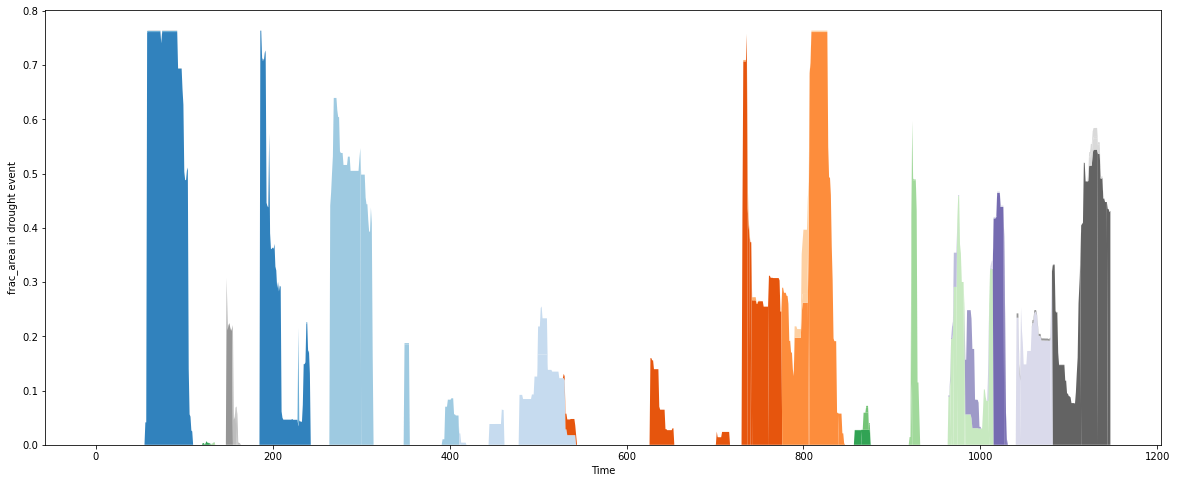

In [6]:
fig, ax = plt.subplots(figsize=(20, 8))

wrangle.plot_drought_evolution(USDM_events, plot_legend=False, ax=ax, plot_var='frac_area', cmap=plt.cm.get_cmap('tab20c'))

SPI_events = dict()

for spi_int in tqdm(spi_intervals):
    try:
        SPI_events[spi_int] = wrangle.encode_drought_events(paired_ds[f'spi_{spi_int}'].values)
    except:
        pass